In [56]:
from glob import glob
import cv2
import albumentations as A
from albumentations.pytorch import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import torch

In [2]:
file_dir = glob('./train/*.jpg')
file_dir[0]

'./train/0986.jpg'

In [80]:
augs1 = A.Compose([
    A.Resize(1024,1024),
    # A.CLAHE(),
    transforms.ToTensor()
])

In [57]:
augs2 = A.Compose([
    A.Resize(1024,1024),
    A.CLAHE(),
    transforms.ToTensor()
])

In [5]:
class loadDataset(Dataset):
    
    def __init__(self, 
                 data: list, 
                 directory: str, 
                 transform = None):
        self.data      = data
        self.directory = directory
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        # import
        image = cv2.imread(self.data[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # augmentations
        if self.transform is not None:
            image = self.transform(image = image)['image']
        
        return image

In [81]:
image_dataset = loadDataset(data = file_dir, 
                         directory ='./train',
                         transform = augs1)

image_loader = DataLoader(image_dataset, 
                          batch_size  = 16, 
                          shuffle     = False, 
                          num_workers = 1,
                          pin_memory  = True)

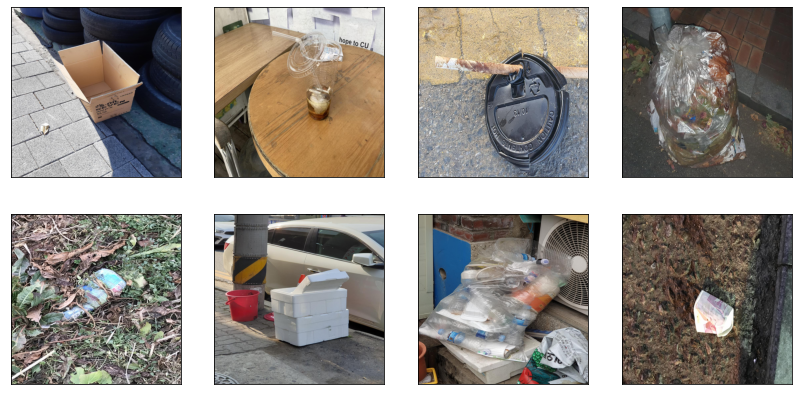

In [34]:
for batch_idx, inputs in enumerate(image_loader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

In [83]:
from tqdm import tqdm
# placeholders
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(image_loader):
    inputs = inputs * 255
    for i in range(3):
        psum[i] += inputs[:,i,:,:].sum(axis=(0,1,2))
        psum_sq[i] += (inputs[:,i,:,:]**2).sum(axis=(0,1,2))

100%|██████████| 306/306 [03:09<00:00,  1.61it/s]


In [84]:
count = len(file_dir) * 1028 * 1028

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([122.6902, 116.4859, 109.2194])
std:  tensor([60.9837, 59.9108, 61.8820])
